In [ ]:
!pip install praw

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 189.3/189.3 kB 1.1 MB/s eta 0:00:00


In [ ]:
# ==============================================================================
# Phase 2: Reddit Autobiographical Narrative Collection
#
# This single script connects to the Reddit API, collects posts based on
# keywords from specified subreddits, anonymizes the text content to remove
# Personally Identifiable Information (PII), and saves the result to a CSV file,
# which is then downloaded to your local machine.
# ==============================================================================

# Step 1: Import all necessary libraries
import praw
import pandas as pd
import re
import time
import datetime
from google.colab import userdata
from google.colab import files

print("‚úÖ Step 1: Libraries imported.")

# ==============================================================================
# Step 2: Configuration and API Credentials
#
# Loads credentials from Colab's secure 'Secrets' manager and sets
# the parameters for the data collection.
# ==============================================================================

try:
    CLIENT_ID = userdata.get('CLIENT_ID')
    CLIENT_SECRET = userdata.get('CLIENT_SECRET')
    USER_AGENT = userdata.get('USER_AGENT')
    print("‚úÖ Step 2: API credentials loaded successfully from Colab Secrets.")
except Exception as e:
    print("‚ùå ERROR: Could not load credentials. Please ensure you have set CLIENT_ID, CLIENT_SECRET, and USER_AGENT in the 'Secrets' tab (key icon on the left).")
    # Stop execution if secrets are not found
    raise e

# --- Search Parameters ---
TARGET_SUBREDDITS = ['offmychest', 'TrueOffMyChest', 'self', 'confession', 'stories']
SEARCH_KEYWORDS = 'remember OR "when I was" OR "I felt" OR realized OR "my story"'
# Start with a smaller limit for testing, increase for full data collection
POST_LIMIT_PER_SUBREDDIT = 100
print("   - Search parameters configured.")

# ==============================================================================
# Step 3: Anonymization Function
#
# Defines the function to remove PII from text using regular expressions.
# This is a critical step for ethical research.
# ==============================================================================

def anonymize_text(text):
    """
    Finds and replaces potential PII in a block of text.
    """
    # Replace email addresses
    text = re.sub(r'\S+@\S+', '[REDACTED_EMAIL]', text)
    # Replace phone numbers
    text = re.sub(r'(\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)\s*\d{3}[-\.\s]??\d{4}|\d{3}[-\.\s]??\d{4})', '[REDACTED_PHONE]', text)
    # Replace Reddit usernames
    text = re.sub(r'(u/|/u/)[A-Za-z0-9_-]+', '[REDACTED_USER]', text)
    # Attempt to replace names after common phrases
    text = re.sub(r'(?i)\b(my name is|I\'m|I am)\s+([A-Z][a-z]+)\b', r'\1 [REDACTED_NAME]', text)
    # Replace simple street addresses
    text = re.sub(r'\d+\s+[A-Z][a-z]+\s+(Street|St|Avenue|Ave|Road|Rd|Drive|Dr|Lane|Ln|Blvd)', '[REDACTED_ADDRESS]', text, flags=re.IGNORECASE)
    return text

print("‚úÖ Step 3: Anonymization function defined.")

# ==============================================================================
# Step 4: Main Data Collection and Execution Logic
#
# This is the main part of the script that runs the data collection process.
# ==============================================================================
def run_collection():
    """
    Main function to execute the entire data collection workflow.
    """
    print("\nüöÄ Starting Data Collection Process...")

    try:
        reddit = praw.Reddit(
            client_id=CLIENT_ID,
            client_secret=CLIENT_SECRET,
            user_agent=USER_AGENT
        )
        print(f"   - Connection to Reddit API successful. Read-only status: {reddit.read_only}")
    except Exception as e:
        print(f"‚ùå ERROR: Failed to connect to Reddit API. Please check your credentials. Error: {e}")
        return

    collected_data = []

    for subreddit_name in TARGET_SUBREDDITS:
        try:
            subreddit = reddit.subreddit(subreddit_name)
            print(f"\n   - Searching in r/{subreddit_name}...")
            post_count = 0
            for post in subreddit.search(SEARCH_KEYWORDS, limit=POST_LIMIT_PER_SUBREDDIT, syntax='cloudsearch'):
                if post.selftext and post.selftext not in ['[removed]', '[deleted]'] and len(post.selftext) > 150:
                    cleaned_text = anonymize_text(post.selftext)
                    data_point = {
                        "id": post.id,
                        "timestamp_utc": post.created_utc,
                        "date_readable": datetime.datetime.fromtimestamp(post.created_utc).strftime('%Y-%m-%d %H:%M:%S'),
                        "subreddit": subreddit_name,
                        "title": post.title,
                        "text_anonymized": cleaned_text,
                        "score": post.score,
                    }
                    collected_data.append(data_point)
                    post_count += 1
            print(f"   - Found and processed {post_count} relevant posts.")
            time.sleep(2)
        except Exception as e:
            print(f"   - ‚ö†Ô∏è WARNING: An error occurred while processing r/{subreddit_name}: {e}")
            continue

    if not collected_data:
        print("\n‚ùå No data was collected. Please check your keywords, subreddit names, or API permissions.")
        return

    print("\n‚úÖ Data collection complete.")

    # --- Data Processing and Saving ---
    df = pd.DataFrame(collected_data)
    print(f"   - Total posts collected: {len(df)}")

    print("\n   - Displaying first 5 rows for verification:")
    display(df.head())

    output_filename = 'reddit_narratives_anonymized.csv'
    df.to_csv(output_filename, index=False, encoding='utf-8-sig')
    print(f"\n   - Data successfully saved to '{output_filename}' in the Colab environment.")

    # --- Download File ---
    print("\n   - Triggering download to your local machine...")
    files.download(output_filename)
    print("\n‚úÖ Workflow Finished.")

# --- Execute the main function ---
run_collection()

‚úÖ Step 1: Libraries imported.


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



‚úÖ Step 2: API credentials loaded successfully from Colab Secrets.
   - Search parameters configured.
‚úÖ Step 3: Anonymization function defined.

üöÄ Starting Data Collection Process...
   - Connection to Reddit API successful. Read-only status: True

   - Searching in r/offmychest...
   - Found and processed 97 relevant posts.


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




   - Searching in r/TrueOffMyChest...
   - Found and processed 97 relevant posts.


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




   - Searching in r/self...
   - Found and processed 92 relevant posts.


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




   - Searching in r/confession...
   - Found and processed 94 relevant posts.


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.




   - Searching in r/stories...
   - Found and processed 98 relevant posts.

‚úÖ Data collection complete.
   - Total posts collected: 478

   - Displaying first 5 rows for verification:


id  timestamp_utc        date_readable   subreddit  \
0   9tn5bc   1.541186e+09  2018-11-02 19:17:11  offmychest   
1  1bxztjs   1.712480e+09  2024-04-07 08:54:03  offmychest   
2   9lojvq   1.538762e+09  2018-10-05 17:50:51  offmychest   
3   rkjqav   1.639994e+09  2021-12-20 09:50:03  offmychest   
4   izgtkd   1.601028e+09  2020-09-25 10:03:08  offmychest   

                                               title  \
0  When I was 13 I kissed a 23 year old friend wh...   
1  Venting My Story Before I Go Say It To My Ther...   
2  I want to tell my story, but there is no one I...   
3                   My dad molested me when I was 11   
4  Reporting sexual assault through Title IX was ...   

                                     text_anonymized  score  
0  This is going to be long, but I‚Äôll try not to ...    276  
1  **Trigger warning!! This will contain topics o...      1  
2  When I was 7 years old, my father raped me for...    149  
3  I (22 F) honestly don't remember how I got int...      6  
4  A couple of years ago I had a disturbing sexua...      6


   - Data successfully saved to 'reddit_narratives_anonymized.csv' in the Colab environment.

   - Triggering download to your local machine...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


‚úÖ Workflow Finished.


üöÄ [Step 1/6] Setting up the environment...
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13.8/13.8 MB 15.0 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 24.6/24.6 MB 9.6 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 883.7/883.7 kB 26.1 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 664.8/664.8 MB 786.5 kB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 211.5/211.5 MB 5.3 MB/s eta 0:00:

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


Analyzing Sentiments:   0%|          | 0/478 [00:00<?, ?it/s]

2025-07-07 07:39:42,983 - BERTopic - Embedding - Transforming documents to embeddings.


‚úÖ Sentiment analysis complete.

üöÄ [Step 4/6] Performing thematic analysis with BERTopic...
   - This is computationally intensive and may take several minutes.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

2025-07-07 07:40:47,495 - BERTopic - Embedding - Completed ‚úì
2025-07-07 07:40:47,496 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-07 07:40:58,738 - BERTopic - Dimensionality - Completed ‚úì
2025-07-07 07:40:58,739 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-07 07:40:58,763 - BERTopic - Cluster - Completed ‚úì
2025-07-07 07:40:58,773 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-07 07:40:59,211 - BERTopic - Representation - Completed ‚úì


‚úÖ BERTopic model training complete.

üöÄ [Step 5/6] Generating primary analysis and visualizations...

--- Analysis 1: Top 15 Most Frequent Topics ---


Topic  Count               Name  \
0      -1    168  -1_to_and_the_was   
1       0     68    0_my_and_to_was   
2       1     56   1_to_and_the_was   
3       2     46   2_to_she_and_her   
4       3     32    3_the_and_to_it   
5       4     31     4_he_and_to_me   
6       5     27     5_the_it_of_to   
7       6     15    6_and_was_to_my   
8       7     13    7_the_and_to_of   
9       8     12   8_was_to_the_and   
10      9     10    9_to_and_the_my   

                                       Representation  \
0       [to, and, the, was, my, that, of, me, it, in]   
1        [my, and, to, was, the, me, she, of, in, he]   
2       [to, and, the, was, my, that, me, of, it, in]   
3     [to, she, and, her, that, the, was, my, me, of]   
4       [the, and, to, it, was, me, in, my, this, of]   
5      [he, and, to, me, him, the, was, it, my, that]   
6      [the, it, of, to, was, and, you, my, in, that]   
7     [and, was, to, my, me, that, the, it, but, her]   
8   [the, and, to, of, that, are, is, in, you, peo...   
9      [was, to, the, and, my, it, that, of, me, had]   
10      [to, and, the, my, was, of, that, it, me, in]   

                                  Representative_Docs  
0   [edit  full transparency this is an alt accoun...  
1   [before you start this is quite long and i apo...  
2   [this is a veryvery long read \n\n\nhello to s...  
3   [this is likely to end up being a bit of a lon...  
4   [this is probably not revolutionary knowledge ...  
5   [a year ago i was pretty naive and unsure of w...  
6   [ \n\nriverstead was nothing like the brothers...  
7   [for quick context inow 32m had pretty difficu...  
8   [i voted for harris but at this point i believ...  
9   [this is my first reddit post ever so please g...  
10  [ive never been good at expressing myself or h...


--- Analysis 2: Average Sentiment Score per Topic (1=Positive, -1=Negative) ---


topic_name  sentiment_numeric
0  2_to_she_and_her           0.000000
1    4_he_and_to_me          -0.225806
2   3_the_and_to_it          -0.281250
3    5_the_it_of_to          -0.296296
4   6_and_was_to_my          -0.400000
5   0_my_and_to_was          -0.426471
6   9_to_and_the_my          -0.600000
7  1_to_and_the_was          -0.642857
8  8_was_to_the_and          -0.666667
9   7_the_and_to_of          -0.692308


üöÄ [Step 6/6] Generating expanded outputs...

--- Analysis 3: Sentiment Distribution of Top 15 Topics ---



--- Analysis 4: Representative Narratives for Top 5 Topics ---

 H_H_H_H_H_H_H_H_H_H_H_H_H_H_H_H_H_H 

Topic 0: 0_my_and_to_was
 H_H_H_H_H_H_H_H_H_H_H_H_H_H_H_H_H_H 

  Representative Doc #1:
  'before you start this is quite long and i apologise for how badly its written i dont really have have an excuse for it i just want to tell someone what ive been through be warned i talk about abuse drug abuse and suicide this isnt every thing but its what ive been writing over the past few days 


when i was 5 i remember mum and dad fighting every night shouting at each other one night my mum screamed at my dad to leave the house all i can remember is crying my eyes out begging him to stay while he told me that it was what my mum wanted it worked and he didnt leave

on my 6th birthday dad came home late from work i later found out that my grandparents missed a london show to stay with me he didnt even say happy birthday when he walked in with me and my friends present at the time this led to a

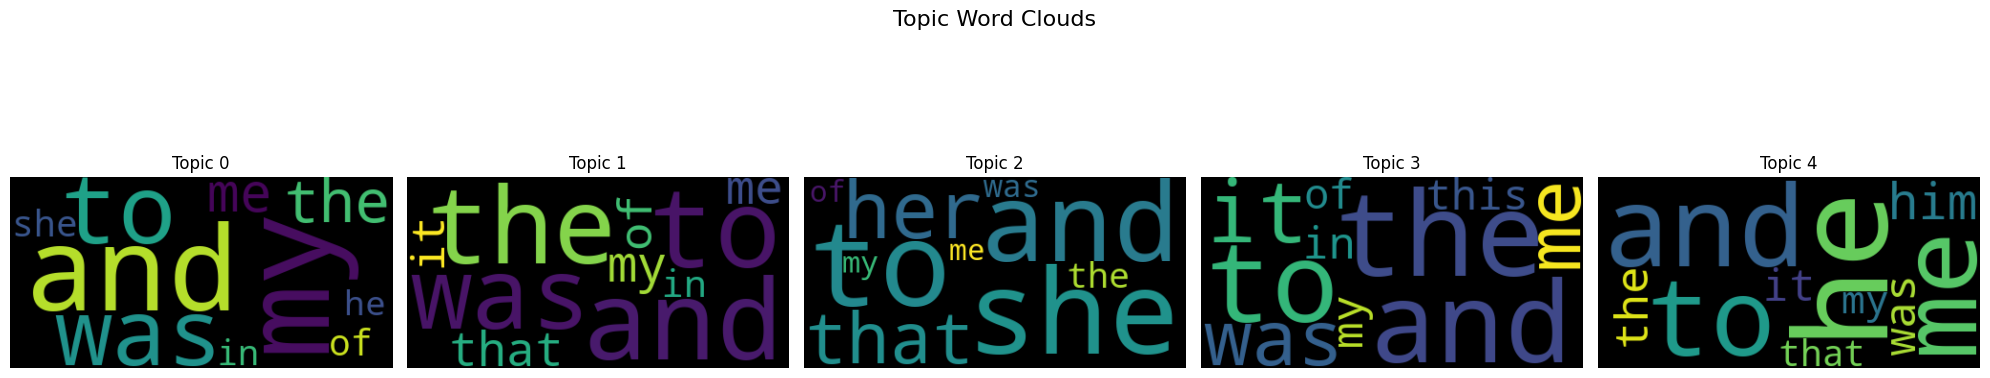


üéâ Workflow Finished! You have now completed a detailed analysis.


In [ ]:
# ==============================================================================
# The Digital Scribe - Full Analysis Pipeline with Expanded Output
# ==============================================================================

# --- Step 1: Setup and Environment Configuration ---
print("üöÄ [Step 1/6] Setting up the environment...")
# Install all required libraries quietly
!pip install pandas torch transformers bertopic tqdm plotly wordcloud -q

# Import modules
import pandas as pd
import re
from tqdm.auto import tqdm

from transformers import pipeline
from bertopic import BERTopic

import plotly.express as px
import plotly.io as pio
from wordcloud import WordCloud
import matplotlib.pyplot as plt

pio.templates.default = "plotly_dark" # Set a visually appealing theme for plots

print("‚úÖ Environment setup complete.\n")


# --- Step 2: Load and Preprocess the Dataset ---
print("üöÄ [Step 2/6] Loading and preprocessing data...")
try:
    # Load the dataset from the uploaded file
    df = pd.read_csv('reddit_narratives_anonymized.csv')
    print(f"   - Dataset loaded successfully with {len(df)} posts.")
except FileNotFoundError:
    print("‚ùå ERROR: 'reddit_narratives_anonymized.csv' not found. Please upload the file using the folder icon on the left before running.")
    # Stop execution if the file isn't found
    raise

def clean_text(text):
    # Helper function for text cleaning
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\/u\/\w+|\/r\/\w+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

df['text_cleaned'] = df['text_anonymized'].apply(clean_text)
print("‚úÖ Data loading and preprocessing complete.\n")


# --- Step 3: Emotional Valence Quantification ---
print("üöÄ [Step 3/6] Performing sentiment analysis...")
print("   - This may take a significant amount of time depending on dataset size.")
# Load a pre-trained model optimized for sentiment
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    device=0 # Use GPU if available
)

def get_sentiment(text):
    # Truncate text to fit the model's max input size
    truncated_text = text[:512]
    try:
        result = sentiment_pipeline(truncated_text)
        return result[0]['label'], result[0]['score']
    except Exception:
        return 'Error', None

# Use tqdm for a progress bar
tqdm.pandas(desc="Analyzing Sentiments")
df[['sentiment_label', 'sentiment_score']] = df['text_cleaned'].progress_apply(
    lambda text: pd.Series(get_sentiment(text))
)
print("‚úÖ Sentiment analysis complete.\n")


# --- Step 4: Thematic Analysis with BERTopic ---
print("üöÄ [Step 4/6] Performing thematic analysis with BERTopic...")
print("   - This is computationally intensive and may take several minutes.")
# For a full run, use all docs. For a quicker test, use a sample.
# docs = df['text_cleaned'].tolist()[:2000]
docs = df['text_cleaned'].tolist()

# Initialize and train the BERTopic model
topic_model = BERTopic(
    embedding_model="all-MiniLM-L6-v2",
    verbose=True
)
topics, probs = topic_model.fit_transform(docs)
df['topic'] = topics
print("‚úÖ BERTopic model training complete.\n")


# --- Step 5: In-Depth Analysis and Visualization ---
print("üöÄ [Step 5/6] Generating primary analysis and visualizations...")

# Get topic info from the model
topic_info = topic_model.get_topic_info()
print("\n--- Analysis 1: Top 15 Most Frequent Topics ---")
display(topic_info.head(16)) # Topic -1 are outliers

# Create a mapping from topic ID to topic name for readable plots
topic_names = {row['Topic']: row['Name'] for index, row in topic_info.iterrows()}
df['topic_name'] = df['topic'].map(topic_names)

# --- Analysis 2: Average Sentiment per Topic ---
sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
df['sentiment_numeric'] = df['sentiment_label'].map(sentiment_map)
sentiment_by_topic = df[df['topic'] != -1].groupby('topic_name')['sentiment_numeric'].mean().sort_values(ascending=False).reset_index()

print("\n--- Analysis 2: Average Sentiment Score per Topic (1=Positive, -1=Negative) ---")
display(sentiment_by_topic)

# Create visualization for average sentiment
top_15_topics = df[df['topic'] != -1]['topic_name'].value_counts().nlargest(15).index
plot_data_avg = sentiment_by_topic[sentiment_by_topic['topic_name'].isin(top_15_topics)]
fig_avg = px.bar(
    plot_data_avg, x='sentiment_numeric', y='topic_name', orientation='h',
    title='Average Sentiment Score of Top 15 Topics',
    labels={'sentiment_numeric': 'Average Sentiment Score (Negative <-> Positive)', 'topic_name': 'Topic'},
    color='sentiment_numeric', color_continuous_scale=px.colors.diverging.RdYlBu, color_continuous_midpoint=0
)
fig_avg.update_layout(yaxis={'categoryorder':'total ascending'})
fig_avg.show()


# --- Step 6: Expanded Output and Deeper Insights ---
print("\nüöÄ [Step 6/6] Generating expanded outputs...")

# --- Analysis 3: Sentiment Distribution per Topic ---
print("\n--- Analysis 3: Sentiment Distribution of Top 15 Topics ---")
# Count sentiments per topic
sentiment_dist = df[df['topic_name'].isin(top_15_topics)].groupby(['topic_name', 'sentiment_label']).size().reset_index(name='count')
# Create a stacked bar chart
fig_dist = px.bar(
    sentiment_dist, x='count', y='topic_name', color='sentiment_label',
    title='Sentiment Distribution of Top 15 Topics', orientation='h',
    labels={'count': 'Number of Posts', 'topic_name': 'Topic', 'sentiment_label': 'Sentiment'},
    category_orders={"sentiment_label": ["positive", "neutral", "negative"]},
    color_discrete_map={'positive': '#2ca02c', 'neutral': '#8c8c8c', 'negative': '#d62728'}
)
fig_dist.update_layout(yaxis={'categoryorder':'total ascending'})
fig_dist.show()


# --- Analysis 4: Representative Narratives per Topic ---
print("\n--- Analysis 4: Representative Narratives for Top 5 Topics ---")
# Get the IDs of the top 5 topics (excluding -1)
top_5_topic_ids = topic_info[topic_info.Topic != -1].head(5)['Topic'].tolist()

for topic_id in top_5_topic_ids:
    topic_name = topic_names[topic_id]
    print(f"\n H_H_H_H_H_H_H_H_H_H_H_H_H_H_H_H_H_H \n")
    print(f"Topic {topic_id}: {topic_name}")
    print(f" H_H_H_H_H_H_H_H_H_H_H_H_H_H_H_H_H_H \n")

    # Get representative documents for the topic
    representative_docs = topic_model.get_representative_docs(topic_id)
    for i, doc in enumerate(representative_docs):
        print(f"  Representative Doc #{i+1}:\n  '{doc}'\n")


# --- Analysis 5: Word Clouds for Top Topics ---
print("\n--- Analysis 5: Word Clouds for Top 5 Topics ---")

def create_wordcloud(model, topic):
    # Get topic words and scores
    text = model.get_topic(topic)
    if not text:
        return None
    # Create dictionary of word:score for the word cloud
    word_scores = {word: score for word, score in text}

    # Create the word cloud object
    wc = WordCloud(background_color="black", max_words=30, colormap="viridis")
    wc.generate_from_frequencies(word_scores)
    return wc

# Generate and display word clouds
fig_wc, axes = plt.subplots(1, len(top_5_topic_ids), figsize=(20, 5))
fig_wc.suptitle('Topic Word Clouds', fontsize=16)

for i, topic_id in enumerate(top_5_topic_ids):
    ax = axes[i]
    wc = create_wordcloud(topic_model, topic_id)
    if wc:
        ax.imshow(wc, interpolation="bilinear")
        ax.set_title(f"Topic {topic_id}")
    ax.axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


print("\nüéâ Workflow Finished! You have now completed a detailed analysis.")

üöÄ [Step 1/6] Setting up the environment...
‚úÖ Environment setup complete.

üöÄ [Step 2/6] Loading and preprocessing data...
   - Dataset loaded successfully with 478 posts.
‚úÖ Data loading and preprocessing complete.

üöÄ [Step 3/6] Performing sentiment analysis...
   - This may take a significant amount of time.


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


Analyzing Sentiments:   0%|          | 0/478 [00:00<?, ?it/s]

2025-07-07 07:48:25,246 - BERTopic - Embedding - Transforming documents to embeddings.


‚úÖ Sentiment analysis complete.

üöÄ [Step 4/6] Performing thematic analysis with BERTopic...
   - This version will remove common English stopwords.


Batches:   0%|          | 0/15 [00:00<?, ?it/s]

2025-07-07 07:49:26,177 - BERTopic - Embedding - Completed ‚úì
2025-07-07 07:49:26,180 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-07 07:49:27,164 - BERTopic - Dimensionality - Completed ‚úì
2025-07-07 07:49:27,165 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-07 07:49:27,190 - BERTopic - Cluster - Completed ‚úì
2025-07-07 07:49:27,195 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-07 07:49:27,590 - BERTopic - Representation - Completed ‚úì


‚úÖ BERTopic model training complete with stopword removal.

üöÄ [Step 5/6] Generating primary analysis and visualizations...

--- Analysis 1: Top 15 Most Frequent Topics (Now Meaningful) ---


Topic  Count                          Name  \
0     -1    164       -1_just_like_time_didnt   
1      0    114           0_just_like_mom_dad   
2      1     49   1_redactedname_like_just_im   
3      2     40        2_time_mary_just_didnt   
4      3     31        3_like_people_woman_im   
5      4     30        4_just_love_james_felt   
6      5     14  5_people_white_americans_men   
7      6     14        6_didnt_said_just_like   
8      7     12          7_got_time_jim_drugs   
9      8     10      8_time_didnt_like_sister   

                                      Representation  \
0  [just, like, time, didnt, im, know, redactedna...   
1  [just, like, mom, dad, didnt, time, im, redact...   
2  [redactedname, like, just, im, know, time, did...   
3  [time, mary, just, didnt, girl, day, like, tol...   
4  [like, people, woman, im, just, man, job, dont...   
5  [just, love, james, felt, time, didnt, know, l...   
6  [people, white, americans, men, trump, social,...   
7  [didnt, said, just, like, mom, time, really, t...   
8  [got, time, jim, drugs, did, like, just, felt,...   
9  [time, didnt, like, sister, school, life, felt...   

                                 Representative_Docs  
0  [i just wanted to put it out somewhere\n\nin o...  
1  [my story has been a hell of a journey how i a...  
2  [this is a veryvery long read \n\n\nhello to s...  
3  [okay i have a story to tell its a long one so...  
4  [im redactedname homeless i do my best to stay...  
5  [a year ago i was pretty naive and unsure of w...  
6  [i voted for harris but at this point i believ...  
7  [tw bullying abuse sh suicidal thoughts depres...  
8  [this is my first reddit post ever so please g...  
9  [ive never been good at expressing myself or h...


--- Analysis 2: Average Sentiment Score per Topic ---


topic_name  sentiment_numeric
0        2_time_mary_just_didnt          -0.050000
1        4_just_love_james_felt          -0.200000
2        3_like_people_woman_im          -0.354839
3        6_didnt_said_just_like          -0.357143
4           0_just_like_mom_dad          -0.394737
5      8_time_didnt_like_sister          -0.500000
6   1_redactedname_like_just_im          -0.632653
7  5_people_white_americans_men          -0.714286
8          7_got_time_jim_drugs          -0.750000


üöÄ [Step 6/6] Generating expanded outputs...

--- Analysis 3: Sentiment Distribution of Top 15 Topics ---



--- Analysis 4: Representative Narratives for Top 5 Topics ---

‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
Topic 0: 0_just_like_mom_dad
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

  Representative Doc #1:
  'my story has been a hell of a journey how i am redactedname at 30 years old i dont even know my story started from when i was just a baby mom and dad were alcoholics and drug addicts who know the real truth so many stories thats been told through the years unfortunately i have to live with the fact i will never know the whole truth my family would rather live in the dark and live with hidden secrets i know one day it will all come to light  as the story of my life is told by family members my mo...'

  Representative Doc #2:
  'hello everyone i 25m am at a loss for words after thi

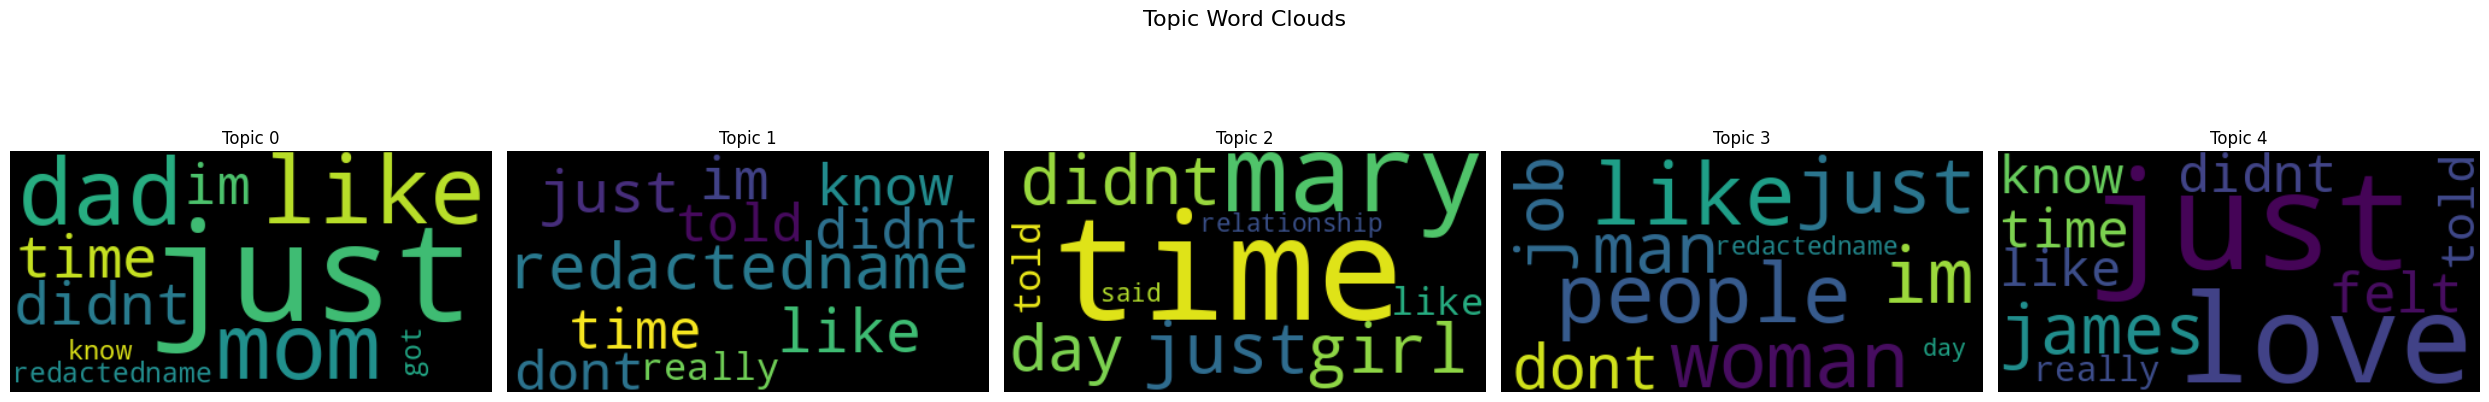


üéâ Workflow Finished! The new topics should now be much more meaningful.


In [ ]:
# ==============================================================================
# The Digital Scribe - Full Analysis Pipeline (v2 - with Stopword Removal)
# ==============================================================================

# --- Step 1: Setup and Environment Configuration ---
print("üöÄ [Step 1/6] Setting up the environment...")
# Install all required libraries quietly
!pip install pandas torch transformers bertopic tqdm plotly wordcloud scikit-learn -q

# Import modules
import pandas as pd
import re
from tqdm.auto import tqdm

from transformers import pipeline
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer # <-- Import CountVectorizer

import plotly.express as px
import plotly.io as pio
from wordcloud import WordCloud
import matplotlib.pyplot as plt

pio.templates.default = "plotly_dark"

print("‚úÖ Environment setup complete.\n")


# --- Step 2: Load and Preprocess the Dataset ---
print("üöÄ [Step 2/6] Loading and preprocessing data...")
try:
    df = pd.read_csv('reddit_narratives_anonymized.csv')
    print(f"   - Dataset loaded successfully with {len(df)} posts.")
except FileNotFoundError:
    print("‚ùå ERROR: 'reddit_narratives_anonymized.csv' not found. Please upload the file first.")
    raise

def clean_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\/u\/\w+|\/r\/\w+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

df['text_cleaned'] = df['text_anonymized'].apply(clean_text)
print("‚úÖ Data loading and preprocessing complete.\n")


# --- Step 3: Emotional Valence Quantification ---
print("üöÄ [Step 3/6] Performing sentiment analysis...")
print("   - This may take a significant amount of time.")
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    device=0
)

def get_sentiment(text):
    truncated_text = text[:512]
    try:
        result = sentiment_pipeline(truncated_text)
        return result[0]['label'], result[0]['score']
    except Exception:
        return 'Error', None

tqdm.pandas(desc="Analyzing Sentiments")
df[['sentiment_label', 'sentiment_score']] = df['text_cleaned'].progress_apply(
    lambda text: pd.Series(get_sentiment(text))
)
print("‚úÖ Sentiment analysis complete.\n")


# --- Step 4: Thematic Analysis with BERTopic (Updated with Stopwords) ---
print("üöÄ [Step 4/6] Performing thematic analysis with BERTopic...")
print("   - This version will remove common English stopwords.")
docs = df['text_cleaned'].tolist()

# -- NEW: Create a vectorizer that knows to remove English stopwords --
vectorizer_model = CountVectorizer(stop_words="english")

# Initialize and train the BERTopic model, passing in the vectorizer
topic_model = BERTopic(
    vectorizer_model=vectorizer_model, # <-- Pass the stopword model here
    embedding_model="all-MiniLM-L6-v2",
    verbose=True
)
topics, probs = topic_model.fit_transform(docs)
df['topic'] = topics
print("‚úÖ BERTopic model training complete with stopword removal.\n")


# --- Step 5: In-Depth Analysis and Visualization ---
print("üöÄ [Step 5/6] Generating primary analysis and visualizations...")
topic_info = topic_model.get_topic_info()
print("\n--- Analysis 1: Top 15 Most Frequent Topics (Now Meaningful) ---")
display(topic_info.head(16))

topic_names = {row['Topic']: row['Name'] for index, row in topic_info.iterrows()}
df['topic_name'] = df['topic'].map(topic_names)

sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
df['sentiment_numeric'] = df['sentiment_label'].map(sentiment_map)
sentiment_by_topic = df[df['topic'] != -1].groupby('topic_name')['sentiment_numeric'].mean().sort_values(ascending=False).reset_index()

print("\n--- Analysis 2: Average Sentiment Score per Topic ---")
display(sentiment_by_topic)

top_15_topics = df[df['topic'] != -1]['topic_name'].value_counts().nlargest(15).index
plot_data_avg = sentiment_by_topic[sentiment_by_topic['topic_name'].isin(top_15_topics)]
fig_avg = px.bar(
    plot_data_avg, x='sentiment_numeric', y='topic_name', orientation='h',
    title='Average Sentiment Score of Top 15 Topics',
    labels={'sentiment_numeric': 'Average Sentiment Score (Negative <-> Positive)', 'topic_name': 'Topic'},
    color='sentiment_numeric', color_continuous_scale=px.colors.diverging.RdYlBu, color_continuous_midpoint=0
)
fig_avg.update_layout(yaxis={'categoryorder':'total ascending'})
fig_avg.show()


# --- Step 6: Expanded Output and Deeper Insights ---
print("\nüöÄ [Step 6/6] Generating expanded outputs...")

# --- Analysis 3: Sentiment Distribution per Topic ---
print("\n--- Analysis 3: Sentiment Distribution of Top 15 Topics ---")
sentiment_dist = df[df['topic_name'].isin(top_15_topics)].groupby(['topic_name', 'sentiment_label']).size().reset_index(name='count')
fig_dist = px.bar(
    sentiment_dist, x='count', y='topic_name', color='sentiment_label',
    title='Sentiment Distribution of Top 15 Topics', orientation='h',
    labels={'count': 'Number of Posts', 'topic_name': 'Topic', 'sentiment_label': 'Sentiment'},
    category_orders={"sentiment_label": ["positive", "neutral", "negative"]},
    color_discrete_map={'positive': '#2ca02c', 'neutral': '#8c8c8c', 'negative': '#d62728'}
)
fig_dist.update_layout(yaxis={'categoryorder':'total ascending'})
fig_dist.show()


# --- Analysis 4: Representative Narratives per Topic ---
print("\n--- Analysis 4: Representative Narratives for Top 5 Topics ---")
top_5_topic_ids = topic_info[topic_info.Topic != -1].head(5)['Topic'].tolist()
for topic_id in top_5_topic_ids:
    topic_name = topic_names[topic_id]
    print(f"\n‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ\nTopic {topic_id}: {topic_name}\n‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ\n")
    representative_docs = topic_model.get_representative_docs(topic_id)
    for i, doc in enumerate(representative_docs):
        print(f"  Representative Doc #{i+1}:\n  '{doc[:500]}...'\n") # Truncate for readability


# --- Analysis 5: Word Clouds for Top Topics ---
print("\n--- Analysis 5: Word Clouds for Top 5 Topics ---")
def create_wordcloud(model, topic):
    text = model.get_topic(topic)
    if not text: return None
    word_scores = {word: score for word, score in text}
    wc = WordCloud(background_color="black", max_words=30, colormap="viridis", width=400, height=200)
    wc.generate_from_frequencies(word_scores)
    return wc

fig_wc, axes = plt.subplots(1, len(top_5_topic_ids), figsize=(25, 5))
fig_wc.suptitle('Topic Word Clouds', fontsize=16)
for i, topic_id in enumerate(top_5_topic_ids):
    ax = axes[i]
    wc = create_wordcloud(topic_model, topic_id)
    if wc:
        ax.imshow(wc, interpolation="bilinear")
        ax.set_title(f"Topic {topic_id}")
    ax.axis("off")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\nüéâ Workflow Finished! The new topics should now be much more meaningful.")


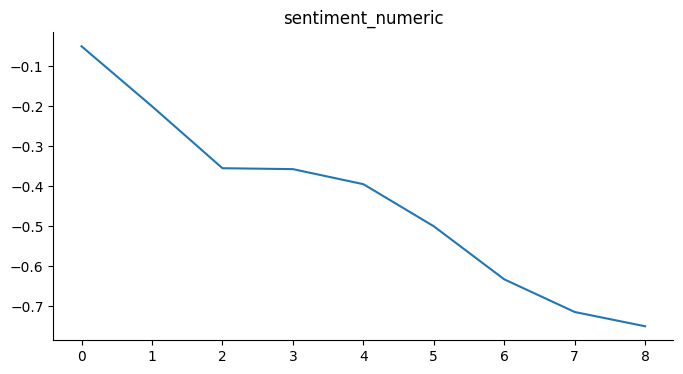

In [ ]:
# @title sentiment_numeric

from matplotlib import pyplot as plt
sentiment_by_topic['sentiment_numeric'].plot(kind='line', figsize=(8, 4), title='sentiment_numeric')
plt.gca().spines[['top', 'right']].set_visible(False)

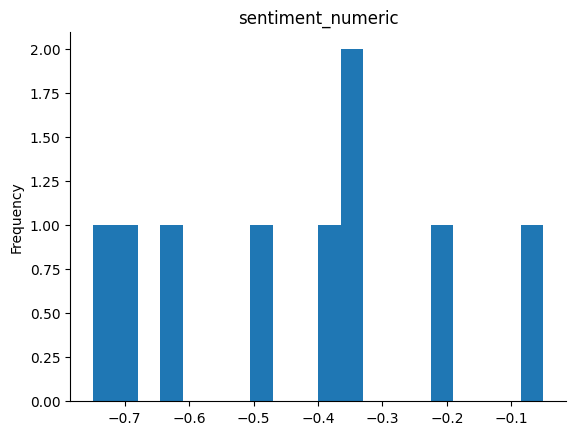

In [ ]:
# @title sentiment_numeric

from matplotlib import pyplot as plt
sentiment_by_topic['sentiment_numeric'].plot(kind='hist', bins=20, title='sentiment_numeric')
plt.gca().spines[['top', 'right',]].set_visible(False)

üöÄ [Step 1/6] Setting up the environment...
‚úÖ Environment setup complete.

üöÄ [Step 2/6] Loading and preprocessing data...
   - Dataset loaded successfully with 478 posts.
‚úÖ Data loading and preprocessing complete.

üöÄ [Step 3/6] Performing sentiment analysis...


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


Analyzing Sentiments:   0%|          | 0/478 [00:00<?, ?it/s]

2025-07-07 08:08:45,960 - BERTopic - Embedding - Transforming documents to embeddings.


‚úÖ Sentiment analysis complete.

üöÄ [Step 4/6] Performing thematic analysis with BERTopic...


Batches:   0%|          | 0/15 [00:00<?, ?it/s]

2025-07-07 08:09:47,059 - BERTopic - Embedding - Completed ‚úì
2025-07-07 08:09:47,061 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-07 08:09:48,040 - BERTopic - Dimensionality - Completed ‚úì
2025-07-07 08:09:48,041 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-07 08:09:48,062 - BERTopic - Cluster - Completed ‚úì
2025-07-07 08:09:48,067 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-07 08:09:48,464 - BERTopic - Representation - Completed ‚úì


‚úÖ BERTopic model training complete.

üöÄ [Step 5/6] Generating primary analysis and visualizations...

--- Analysis 1: Top 15 Most Frequent Topics ---


Topic  Count                           Name  \
0     -1    193          -1_know_said_felt_did   
1      0    132         0_know_told_did_really   
2      1     54          1_dad_mom_mother_life   
3      2     27         2_people_woman_man_job   
4      3     19  3_captain_arthur_voice_flight   
5      4     14         4_mom_jacob_did_things   
6      5     13  5_brother_did_family_remember   
7      6     13            6_felt_did_went_jim   
8      7     13   7_people_white_americans_men   

                                      Representation  \
0  [know, said, felt, did, told, really, people, ...   
1  [know, told, did, really, said, felt, started,...   
2  [dad, mom, mother, life, told, day, years, sch...   
3  [people, woman, man, job, work, day, manager, ...   
4  [captain, arthur, voice, flight, kid, said, lo...   
5  [mom, jacob, did, things, lisas, girls, know, ...   
6  [brother, did, family, remember, feel, younger...   
7  [felt, did, went, jim, friends, drugs, years, ...   
8  [people, white, americans, men, trump, social,...   

                                 Representative_Docs  
0  [ive never been good at expressing myself or h...  
1  [ im redactedname this with an open wound as t...  
2  [my story has been a hell of a journey how i a...  
3  [this is probably not revolutionary knowledge ...  
4  [\n\n i work on cargo ships long hauls across ...  
5  [for quick context inow 32m had pretty difficu...  
6  [when i was 9 i had a friend that i would go t...  
7  [this is my first reddit post ever so please g...  
8  [i voted for harris but at this point i believ...


--- Analysis 2: Average Sentiment Score per Topic ---


topic_name  sentiment_numeric
0  3_captain_arthur_voice_flight          -0.263158
1         0_know_told_did_really          -0.265152
2         4_mom_jacob_did_things          -0.357143
3         2_people_woman_man_job          -0.370370
4  5_brother_did_family_remember          -0.384615
5          1_dad_mom_mother_life          -0.462963
6            6_felt_did_went_jim          -0.692308
7   7_people_white_americans_men          -0.692308


üöÄ [Step 6/6] Generating expanded outputs...

--- Analysis 3: Sentiment Distribution of Top 15 Topics ---



--- Analysis 4: Average Sentiment Score per Subreddit ---



--- Analysis 5: Representative Narratives for Top 5 Topics ---

‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
Topic 0: 0_know_told_did_really
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

  Representative Doc #1:
  ' im redactedname this with an open wound as things were ended yesterday i wrote this on november 22 2019


before i go into my story i would want to start it off by briefly talking about how i was before i found love

for the longest time that i can remember i would always pray to the lord that he gives me the right girl for me the girl that clicks perfectly with me the girl that i can listen to love songs with as we share all the emotions portrayed in the song the girl who would love me as i lo...'

  Representative Doc #2:
  'hi guys this is my story about how me and my strai

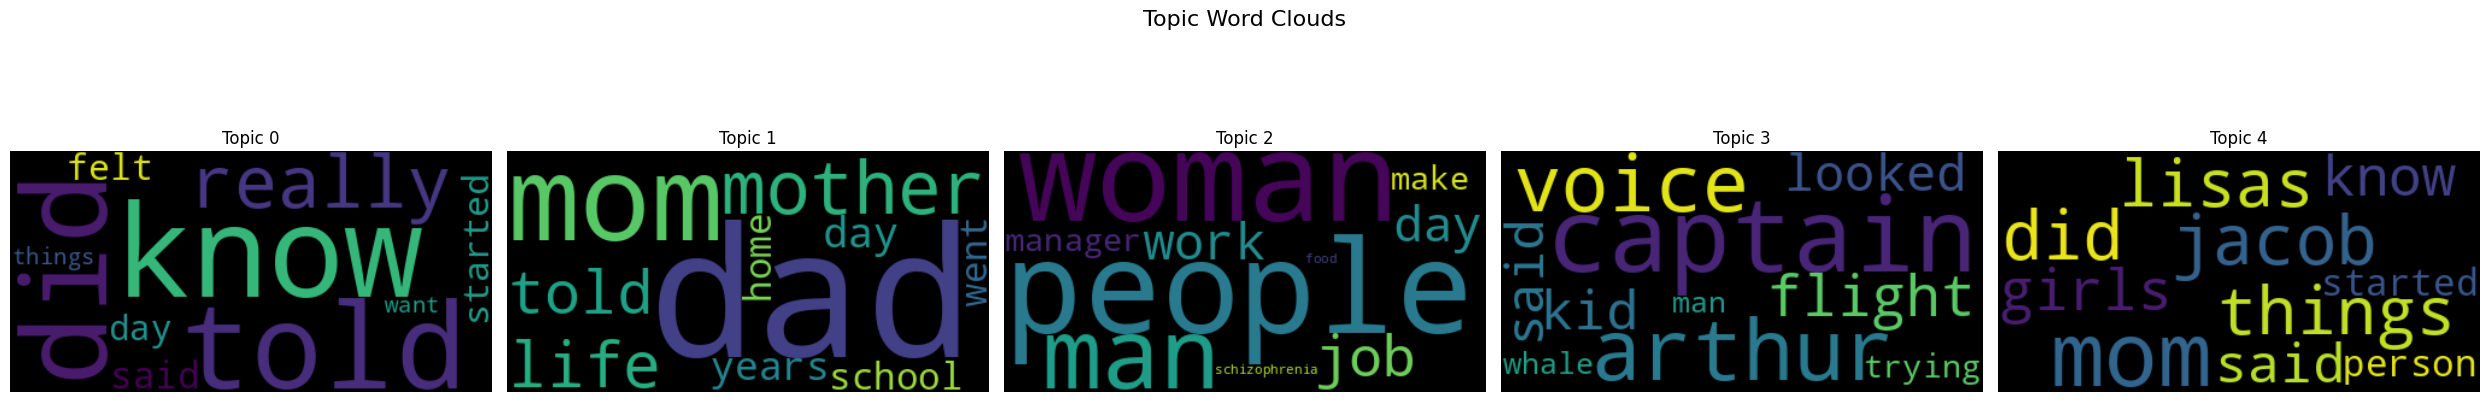


üéâ Workflow Finished! You have now completed a comprehensive analysis with multiple visualizations.


In [ ]:
# ==============================================================================
# The Digital Scribe - Full Analysis Pipeline (v4 - with Subreddit Analysis)
# ==============================================================================

# --- Step 1: Setup and Environment Configuration ---
print("üöÄ [Step 1/6] Setting up the environment...")
# Install all required libraries quietly
!pip install pandas torch transformers bertopic tqdm plotly wordcloud scikit-learn -q

# Import modules
import pandas as pd
import re
from tqdm.auto import tqdm

from transformers import pipeline
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

import plotly.express as px
import plotly.io as pio
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from google.colab import files

pio.templates.default = "plotly_dark"

print("‚úÖ Environment setup complete.\n")


# --- Step 2: Load and Preprocess the Dataset ---
print("üöÄ [Step 2/6] Loading and preprocessing data...")
try:
    df = pd.read_csv('reddit_narratives_anonymized.csv')
    print(f"   - Dataset loaded successfully with {len(df)} posts.")
except FileNotFoundError:
    print("‚ùå ERROR: 'reddit_narratives_anonymized.csv' not found. Please upload the file first.")
    raise

def clean_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\/u\/\w+|\/r\/\w+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

df['text_cleaned'] = df['text_anonymized'].apply(clean_text)
print("‚úÖ Data loading and preprocessing complete.\n")


# --- Step 3: Emotional Valence Quantification ---
print("üöÄ [Step 3/6] Performing sentiment analysis...")
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    device=0
)
tqdm.pandas(desc="Analyzing Sentiments")
df[['sentiment_label', 'sentiment_score']] = df['text_cleaned'].progress_apply(
    lambda text: pd.Series(sentiment_pipeline(text[:512])[0])
)
print("‚úÖ Sentiment analysis complete.\n")


# --- Step 4: Thematic Analysis with BERTopic (with Stopwords) ---
print("üöÄ [Step 4/6] Performing thematic analysis with BERTopic...")
docs = df['text_cleaned'].tolist()
custom_stopwords = ["im", "just", "like", "redactedname", "dont", "didnt", "time", "ive", "wasnt", "got"]
english_stopwords = list(CountVectorizer(stop_words='english').get_stop_words())
full_stopword_list = english_stopwords + custom_stopwords
vectorizer_model = CountVectorizer(stop_words=full_stopword_list)

topic_model = BERTopic(
    vectorizer_model=vectorizer_model,
    embedding_model="all-MiniLM-L6-v2",
    verbose=True
)
topics, probs = topic_model.fit_transform(docs)
df['topic'] = topics
print("‚úÖ BERTopic model training complete.\n")


# --- Step 5: In-Depth Analysis and Visualization ---
print("üöÄ [Step 5/6] Generating primary analysis and visualizations...")

topic_info = topic_model.get_topic_info()
print("\n--- Analysis 1: Top 15 Most Frequent Topics ---")
display(topic_info.head(16))

topic_names = {row['Topic']: row['Name'] for index, row in topic_info.iterrows()}
df['topic_name'] = df['topic'].map(topic_names)
sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
df['sentiment_numeric'] = df['sentiment_label'].map(sentiment_map)
sentiment_by_topic = df[df['topic'] != -1].groupby('topic_name')['sentiment_numeric'].mean().sort_values(ascending=False).reset_index()

print("\n--- Analysis 2: Average Sentiment Score per Topic ---")
display(sentiment_by_topic)

top_15_topics = df[df['topic'] != -1]['topic_name'].value_counts().nlargest(15).index
plot_data_avg = sentiment_by_topic[sentiment_by_topic['topic_name'].isin(top_15_topics)]
fig_avg = px.bar(
    plot_data_avg, x='sentiment_numeric', y='topic_name', orientation='h',
    title='Average Sentiment Score of Top 15 Topics',
    labels={'sentiment_numeric': 'Average Sentiment Score (Negative <-> Positive)', 'topic_name': 'Topic'},
    color='sentiment_numeric', color_continuous_scale=px.colors.diverging.RdYlBu, color_continuous_midpoint=0
)
fig_avg.update_layout(yaxis={'categoryorder':'total ascending'})
fig_avg.show()


# --- Step 6: Expanded Output and Deeper Insights ---
print("\nüöÄ [Step 6/6] Generating expanded outputs...")

# --- Analysis 3: Sentiment Distribution per Topic ---
print("\n--- Analysis 3: Sentiment Distribution of Top 15 Topics ---")
sentiment_dist = df[df['topic_name'].isin(top_15_topics)].groupby(['topic_name', 'sentiment_label']).size().reset_index(name='count')
fig_dist = px.bar(
    sentiment_dist, x='count', y='topic_name', color='sentiment_label',
    title='Sentiment Distribution of Top 15 Topics', orientation='h',
    labels={'count': 'Number of Posts', 'topic_name': 'Topic', 'sentiment_label': 'Sentiment'},
    category_orders={"sentiment_label": ["positive", "neutral", "negative"]},
    color_discrete_map={'positive': '#2ca02c', 'neutral': '#8c8c8c', 'negative': '#d62728'}
)
fig_dist.update_layout(yaxis={'categoryorder':'total ascending'})
fig_dist.show()


# --- Analysis 4: Sentiment by Source Subreddit (NEWLY ADDED) ---
print("\n--- Analysis 4: Average Sentiment Score per Subreddit ---")
sentiment_by_subreddit = df.groupby('subreddit')['sentiment_numeric'].mean().sort_values().reset_index()
fig_sub = px.bar(
    sentiment_by_subreddit,
    x='subreddit',
    y='sentiment_numeric',
    title='Average Sentiment Score by Subreddit',
    labels={'sentiment_numeric': 'Average Sentiment (Negative <-> Positive)', 'subreddit': 'Subreddit'},
    color='sentiment_numeric',
    color_continuous_scale=px.colors.diverging.RdYlBu,
    color_continuous_midpoint=0
)
fig_sub.show()


# --- Analysis 5: Representative Narratives per Topic ---
print("\n--- Analysis 5: Representative Narratives for Top 5 Topics ---")
top_5_topic_ids = topic_info[topic_info.Topic != -1].head(5)['Topic'].tolist()
for topic_id in top_5_topic_ids:
    topic_name = topic_names[topic_id]
    print(f"\n‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ\nTopic {topic_id}: {topic_name}\n‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ\n")
    representative_docs = topic_model.get_representative_docs(topic_id)
    for i, doc in enumerate(representative_docs):
        print(f"  Representative Doc #{i+1}:\n  '{doc[:500]}...'\n")


# --- Analysis 6: Word Clouds for Top Topics ---
print("\n--- Analysis 6: Word Clouds for Top 5 Topics ---")
def create_wordcloud(model, topic):
    text = model.get_topic(topic)
    if not text: return None
    word_scores = {word: score for word, score in text}
    wc = WordCloud(background_color="black", max_words=30, colormap="viridis", width=400, height=200)
    wc.generate_from_frequencies(word_scores)
    return wc

fig_wc, axes = plt.subplots(1, len(top_5_topic_ids), figsize=(25, 5))
fig_wc.suptitle('Topic Word Clouds', fontsize=16)
for i, topic_id in enumerate(top_5_topic_ids):
    ax = axes[i]
    wc = create_wordcloud(topic_model, topic_id)
    if wc:
        ax.imshow(wc, interpolation="bilinear")
        ax.set_title(f"Topic {topic_id}")
    ax.axis("off")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\nüéâ Workflow Finished! You have now completed a comprehensive analysis with multiple visualizations.")

In [ ]:
# --- Analysis 3: Sentiment Distribution per Topic ---
print("\n--- Analysis 3: Sentiment Distribution of Top 15 Topics ---")
sentiment_dist = df[df['topic_name'].isin(top_15_topics)].groupby(['topic_name', 'sentiment_label']).size().reset_index(name='count')
fig_dist = px.bar(
    sentiment_dist, x='count', y='topic_name', color='sentiment_label',
    title='Sentiment Distribution of Top 15 Topics', orientation='h',
    labels={'count': 'Number of Posts', 'topic_name': 'Topic', 'sentiment_label': 'Sentiment'},
    category_orders={"sentiment_label": ["positive", "neutral", "negative"]},
    color_discrete_map={'positive': '#2ca02c', 'neutral': '#8c8c8c', 'negative': '#d62728'}
)
fig_dist.update_layout(yaxis={'categoryorder':'total ascending'})
fig_dist.show()


# --- Analysis 4: Sentiment by Source Subreddit (NEWLY ADDED) ---
print("\n--- Analysis 4: Average Sentiment Score per Subreddit ---")
sentiment_by_subreddit = df.groupby('subreddit')['sentiment_numeric'].mean().sort_values().reset_index()
fig_sub = px.bar(
    sentiment_by_subreddit,
    x='subreddit',
    y='sentiment_numeric',
    title='Average Sentiment Score by Subreddit',
    labels={'sentiment_numeric': 'Average Sentiment (Negative <-> Positive)', 'subreddit': 'Subreddit'},
    color='sentiment_numeric',
    color_continuous_scale=px.colors.diverging.RdYlBu,
    color_continuous_midpoint=0
)
fig_sub.show()


--- Analysis 3: Sentiment Distribution of Top 15 Topics ---



--- Analysis 4: Average Sentiment Score per Subreddit ---


In [ ]:
topic_info = topic_model.get_topic_info()
print("\n--- Analysis 1: Top 15 Most Frequent Topics ---")
display(topic_info.head(16))

topic_names = {row['Topic']: row['Name'] for index, row in topic_info.iterrows()}
df['topic_name'] = df['topic'].map(topic_names)
sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
df['sentiment_numeric'] = df['sentiment_label'].map(sentiment_map)
sentiment_by_topic = df[df['topic'] != -1].groupby('topic_name')['sentiment_numeric'].mean().sort_values(ascending=False).reset_index()

print("\n--- Analysis 2: Average Sentiment Score per Topic ---")
display(sentiment_by_topic)

top_15_topics = df[df['topic'] != -1]['topic_name'].value_counts().nlargest(15).index
plot_data_avg = sentiment_by_topic[sentiment_by_topic['topic_name'].isin(top_15_topics)]
fig_avg = px.bar(
    plot_data_avg, x='sentiment_numeric', y='topic_name', orientation='h',
    title='Average Sentiment Score of Top 15 Topics',
    labels={'sentiment_numeric': 'Average Sentiment Score (Negative <-> Positive)', 'topic_name': 'Topic'},
    color='sentiment_numeric', color_continuous_scale=px.colors.diverging.RdYlBu, color_continuous_midpoint=0
)
fig_avg.update_layout(yaxis={'categoryorder':'total ascending'})
fig_avg.show()


--- Analysis 1: Top 15 Most Frequent Topics ---


Topic  Count                           Name  \
0     -1    193          -1_know_said_felt_did   
1      0    132         0_know_told_did_really   
2      1     54          1_dad_mom_mother_life   
3      2     27         2_people_woman_man_job   
4      3     19  3_captain_arthur_voice_flight   
5      4     14         4_mom_jacob_did_things   
6      5     13  5_brother_did_family_remember   
7      6     13            6_felt_did_went_jim   
8      7     13   7_people_white_americans_men   

                                      Representation  \
0  [know, said, felt, did, told, really, people, ...   
1  [know, told, did, really, said, felt, started,...   
2  [dad, mom, mother, life, told, day, years, sch...   
3  [people, woman, man, job, work, day, manager, ...   
4  [captain, arthur, voice, flight, kid, said, lo...   
5  [mom, jacob, did, things, lisas, girls, know, ...   
6  [brother, did, family, remember, feel, younger...   
7  [felt, did, went, jim, friends, drugs, years, ...   
8  [people, white, americans, men, trump, social,...   

                                 Representative_Docs  
0  [ive never been good at expressing myself or h...  
1  [ im redactedname this with an open wound as t...  
2  [my story has been a hell of a journey how i a...  
3  [this is probably not revolutionary knowledge ...  
4  [\n\n i work on cargo ships long hauls across ...  
5  [for quick context inow 32m had pretty difficu...  
6  [when i was 9 i had a friend that i would go t...  
7  [this is my first reddit post ever so please g...  
8  [i voted for harris but at this point i believ...


--- Analysis 2: Average Sentiment Score per Topic ---


topic_name  sentiment_numeric
0  3_captain_arthur_voice_flight          -0.263158
1         0_know_told_did_really          -0.265152
2         4_mom_jacob_did_things          -0.357143
3         2_people_woman_man_job          -0.370370
4  5_brother_did_family_remember          -0.384615
5          1_dad_mom_mother_life          -0.462963
6            6_felt_did_went_jim          -0.692308
7   7_people_white_americans_men          -0.692308


--- Analysis 5: Representative Narratives for Top 5 Topics ---

‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
Topic 0: 0_know_told_did_really
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

  Representative Doc #1:
  ' im redactedname this with an open wound as things were ended yesterday i wrote this on november 22 2019


before i go into my story i would want to start it off by briefly talking about how i was before i found love

for the longest time that i can remember i would always pray to the lord that he gives me the right girl for me the girl that clicks perfectly with me the girl that i can listen to love songs with as we share all the emotions portrayed in the song the girl who would love me as i lo...'

  Representative Doc #2:
  'hi guys this is my story about how me and my strai

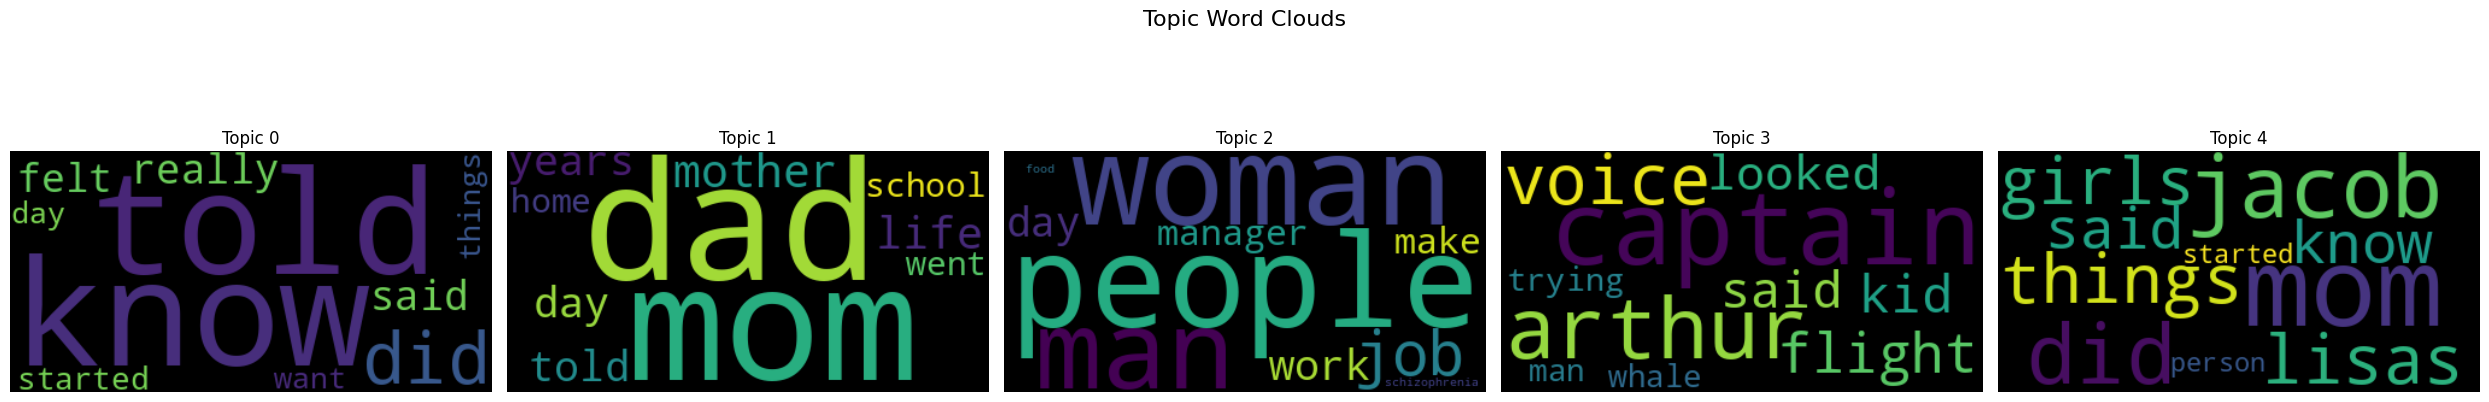

In [ ]:
# --- Analysis 5: Representative Narratives per Topic ---
print("\n--- Analysis 5: Representative Narratives for Top 5 Topics ---")
top_5_topic_ids = topic_info[topic_info.Topic != -1].head(5)['Topic'].tolist()
for topic_id in top_5_topic_ids:
    topic_name = topic_names[topic_id]
    print(f"\n‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ\nTopic {topic_id}: {topic_name}\n‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ\n")
    representative_docs = topic_model.get_representative_docs(topic_id)
    for i, doc in enumerate(representative_docs):
        print(f"  Representative Doc #{i+1}:\n  '{doc[:500]}...'\n")


# --- Analysis 6: Word Clouds for Top Topics ---
print("\n--- Analysis 6: Word Clouds for Top 5 Topics ---")
def create_wordcloud(model, topic):
    text = model.get_topic(topic)
    if not text: return None
    word_scores = {word: score for word, score in text}
    wc = WordCloud(background_color="black", max_words=30, colormap="viridis", width=400, height=200)
    wc.generate_from_frequencies(word_scores)
    return wc

fig_wc, axes = plt.subplots(1, len(top_5_topic_ids), figsize=(25, 5))
fig_wc.suptitle('Topic Word Clouds', fontsize=16)
for i, topic_id in enumerate(top_5_topic_ids):
    ax = axes[i]
    wc = create_wordcloud(topic_model, topic_id)
    if wc:
        ax.imshow(wc, interpolation="bilinear")
        ax.set_title(f"Topic {topic_id}")
    ax.axis("off")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [2]:
# ==============================================================================
# Model Generation and Saving Pipeline
#
# This script performs the following actions:
# 1. Installs and imports necessary libraries.
# 2. Loads and preprocesses the collected Reddit data.
# 3. Loads a pre-trained sentiment analysis model and saves it for reuse.
# 4. Trains a BERTopic model on the data and saves the result.
# 5. Packages and downloads the saved models to your computer.
# ==============================================================================

# --- Step 1: Setup and Environment Configuration ---
print("üöÄ [Step 1/5] Setting up the environment...")
# Install all required libraries quietly
!pip install pandas torch transformers bertopic scikit-learn -q

# Import modules
import pandas as pd
import re
import shutil
from google.colab import files

from transformers import pipeline
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

print("‚úÖ Environment setup complete.\n")


# --- Step 2: Load and Preprocess the Dataset ---
print("üöÄ [Step 2/5] Loading and preprocessing data...")
try:
    df = pd.read_csv('reddit_narratives_anonymized.csv')
    print(f"   - Dataset loaded successfully with {len(df)} posts.")
except FileNotFoundError:
    print("‚ùå ERROR: 'reddit_narratives_anonymized.csv' not found. Please upload the file first.")
    raise

def clean_text(text):
    # Helper function for text cleaning
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\/u\/\w+|\/r\/\w+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

df['text_cleaned'] = df['text_anonymized'].apply(clean_text)
print("‚úÖ Data loading and preprocessing complete.\n")


# --- Step 3: Generate and Save Sentiment Model ---
print("üöÄ [Step 3/5] Initializing and saving the sentiment analysis model...")
# Load a pre-trained model from Hugging Face. This isn't "training" but rather
# creating and configuring a usable pipeline instance.
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    device=0 # Use GPU if available
)

# Define the path and save the model components
SENTIMENT_MODEL_PATH = "./sentiment_model_roberta"
sentiment_pipeline.save_pretrained(SENTIMENT_MODEL_PATH)
print(f"‚úÖ Sentiment model pipeline saved to directory: {SENTIMENT_MODEL_PATH}\n")


# --- Step 4: Generate and Save Topic Model ---
print("üöÄ [Step 4/5] Training and saving the BERTopic model...")
# Prepare the text data for the model
docs = df['text_cleaned'].tolist()

# Define a custom stopword list to improve topic quality
custom_stopwords = ["im", "just", "like", "redactedname", "dont", "didnt", "time", "ive", "wasnt", "got"]
english_stopwords = list(CountVectorizer(stop_words='english').get_stop_words())
full_stopword_list = english_stopwords + custom_stopwords
vectorizer_model = CountVectorizer(stop_words=full_stopword_list)

# Initialize the BERTopic model with the stopword list
topic_model = BERTopic(
    vectorizer_model=vectorizer_model,
    embedding_model="all-MiniLM-L6-v2",
    verbose=True
)

# This is the main training step. It can take several minutes.
print("   - Training BERTopic model on the data...")
topics, probs = topic_model.fit_transform(docs)
print("   - Model training complete.")

# Define the path and save the trained model
BERTOPIC_MODEL_PATH = "finetuned_bertopic_model"
topic_model.save(BERTOPIC_MODEL_PATH, serialization="safetensors")
print(f"‚úÖ BERTopic model saved to file: {BERTOPIC_MODEL_PATH}\n")


# --- Step 5: Package and Download Saved Models ---
print("üöÄ [Step 5/5] Packaging and downloading models...")

# Zip the sentiment model directory for easy download
shutil.make_archive('sentiment_model', 'zip', SENTIMENT_MODEL_PATH)
print("   - Zipping sentiment model to 'sentiment_model.zip'")
print(f"   - BERTopic model saved as '{BERTOPIC_MODEL_PATH}'")

print("\nDownloading all saved model files to your local machine...")
files.download('sentiment_model.zip')
files.download(BERTOPIC_MODEL_PATH)

print("\nüéâ Workflow Finished! Your trained models have been generated, saved, and downloaded.")

üöÄ [Step 1/5] Setting up the environment...
‚úÖ Environment setup complete.

üöÄ [Step 2/5] Loading and preprocessing data...
   - Dataset loaded successfully with 478 posts.
‚úÖ Data loading and preprocessing complete.

üöÄ [Step 3/5] Initializing and saving the sentiment analysis model...


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu
2025-07-08 01:49:48,663 - BERTopic - Embedding - Transforming documents to embeddings.


‚úÖ Sentiment model pipeline saved to directory: ./sentiment_model_roberta

üöÄ [Step 4/5] Training and saving the BERTopic model...
   - Training BERTopic model on the data...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/15 [00:00<?, ?it/s]

2025-07-08 01:51:03,238 - BERTopic - Embedding - Completed ‚úì
2025-07-08 01:51:03,239 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-08 01:51:13,562 - BERTopic - Dimensionality - Completed ‚úì
2025-07-08 01:51:13,564 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-08 01:51:13,587 - BERTopic - Cluster - Completed ‚úì
2025-07-08 01:51:13,603 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-08 01:51:14,071 - BERTopic - Representation - Completed ‚úì


   - Model training complete.
‚úÖ BERTopic model saved to file: finetuned_bertopic_model

üöÄ [Step 5/5] Packaging and downloading models...
   - Zipping sentiment model to 'sentiment_model.zip'
   - BERTopic model saved as 'finetuned_bertopic_model'



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


üéâ Workflow Finished! Your trained models have been generated, saved, and downloaded.


In [3]:
# ==============================================================================
# 'Cognitive Echo' - A Clinical Support Prototype
#
# This notebook builds and launches a web application to analyze new narratives
# using the sentiment and topic models trained in the previous phases.
# ==============================================================================

# --- Step 1: Setup and Environment Configuration ---
print("üöÄ [Step 1/5] Setting up the environment...")
# Install all required libraries quietly
!pip install gradio transformers bertopic torch sentence_transformers -q

# Import modules
import gradio as gr
import pandas as pd
import zipfile
import os

from transformers import pipeline
from bertopic import BERTopic

print("‚úÖ Environment setup complete.\n")


# --- Step 2: Load the Trained Models ---
print("üöÄ [Step 2/5] Loading your saved models...")

# --- Load Sentiment Analysis Model ---
SENTIMENT_ZIP_PATH = 'sentiment_model.zip'
SENTIMENT_MODEL_DIR = './sentiment_model_roberta'

try:
    # Unzip the saved sentiment model directory
    with zipfile.ZipFile(SENTIMENT_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall('./')

    # Load the pipeline from the extracted directory
    sentiment_pipeline = pipeline(
        "sentiment-analysis",
        model=SENTIMENT_MODEL_DIR,
        device=0 # Use GPU if available
    )
    print("‚úÖ Sentiment model loaded successfully.")
except FileNotFoundError:
    print(f"‚ùå ERROR: Could not find '{SENTIMENT_ZIP_PATH}'. Please upload the file.")
    raise

# --- Load BERTopic Model ---
BERTOPIC_MODEL_PATH = "finetuned_bertopic_model"
try:
    topic_model = BERTopic.load(BERTOPIC_MODEL_PATH)
    print("‚úÖ BERTopic model loaded successfully.")
except FileNotFoundError:
    print(f"‚ùå ERROR: Could not find '{BERTOPIC_MODEL_PATH}'. Please upload the file.")
    raise

# We need the topic names from our previous analysis to make the output readable.
# This mapping should be saved from your previous analysis. Here we define it manually.
TOPIC_NAME_MAPPING = {
    -1: "Outlier/No specific topic",
    0: "Family & Childhood Trauma",
    1: "Meta-Narratives & Mental Health",
    2: "Romantic Relationships",
    3: "Social Identity & Perception",
    4: "Social & Political Commentary",
    # Add more mappings here as needed based on your topic_info.csv
}
print("‚úÖ Topic name mapping created.\n")


# --- Step 3: Build the Core Analysis Function ---
print("üöÄ [Step 3/5] Building the prediction function...")

def analyze_narrative(narrative_text):
    """
    This function takes new text, runs it through both models,
    and returns a structured analysis.
    """
    if not isinstance(narrative_text, str) or len(narrative_text.strip()) < 20:
        return {"Error": "Please enter a narrative longer than 20 characters."}

    # 1. Perform Sentiment Analysis
    try:
        sentiment_result = sentiment_pipeline(narrative_text[:512])[0]
        sentiment_label = sentiment_result['label'].upper()
        sentiment_score = round(sentiment_result['score'], 4)
    except Exception as e:
        sentiment_label = "Error"
        sentiment_score = str(e)

    # 2. Perform Topic Analysis
    try:
        # The `transform` method predicts topics for new documents
        topic_id, _ = topic_model.transform([narrative_text])
        predicted_topic_id = topic_id[0]
        # Look up the human-readable name
        predicted_topic_name = TOPIC_NAME_MAPPING.get(predicted_topic_id, "Unknown Topic")
    except Exception as e:
        predicted_topic_id = "Error"
        predicted_topic_name = str(e)

    # 3. Format the output
    analysis_output = {
        "Sentiment Analysis": {
            "Overall Sentiment": sentiment_label,
            "Confidence Score": sentiment_score
        },
        "Thematic Analysis": {
            "Predicted Topic ID": predicted_topic_id,
            "Predicted Topic Name": predicted_topic_name
        }
    }

    return analysis_output

print("‚úÖ Core analysis function is ready.\n")


# --- Step 4: Create and Launch the Gradio Web Interface ---
print("üöÄ [Step 4/5] Creating the Gradio web interface...")

interface = gr.Interface(
    fn=analyze_narrative,
    inputs=gr.Textbox(
        lines=15,
        label="Enter Your Personal Narrative Here",
        placeholder="Write about a significant memory or experience..."
    ),
    outputs=gr.JSON(label="Analysis Results"),
    title="üß† Cognitive Echo: A Narrative Analysis Prototype",
    description="This prototype uses AI to analyze the emotional valence and thematic content of personal narratives. It is based on the 'Digital Scribe' research project and is intended as a proof-of-concept for a clinical support tool. This is NOT a diagnostic tool.",
    allow_flagging="never"
)

print("‚úÖ Gradio interface created.\n")


# --- Step 5: Launch the Application ---
print("üöÄ [Step 5/5] Launching the application...")
print("   - A public link will be generated below. Click it to open the web app in a new tab.")

# launch() will create a local server and, with share=True, a temporary public link
interface.launch(debug=True, share=True)

üöÄ [Step 1/5] Setting up the environment...
‚úÖ Environment setup complete.

üöÄ [Step 2/5] Loading your saved models...


Device set to use cpu


‚úÖ Sentiment model loaded successfully.
‚úÖ BERTopic model loaded successfully.
‚úÖ Topic name mapping created.

üöÄ [Step 3/5] Building the prediction function...
‚úÖ Core analysis function is ready.

üöÄ [Step 4/5] Creating the Gradio web interface...
‚úÖ Gradio interface created.

üöÄ [Step 5/5] Launching the application...
   - A public link will be generated below. Click it to open the web app in a new tab.
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://5ee4dd5d23e0f536f5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 02:22:57,336 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 02:24:19,488 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 02:24:28,598 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 02:24:50,595 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 02:25:20,874 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 02:25:48,344 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 02:25:55,129 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 02:26:34,127 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 02:27:34,831 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 02:33:25,463 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 02:34:23,063 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 02:35:40,248 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 02:35:51,252 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 02:43:14,247 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 02:44:16,360 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 02:44:27,157 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 02:44:35,267 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 02:44:43,767 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 02:45:05,398 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 02:45:13,914 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 02:45:25,152 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 02:52:00,311 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 02:53:59,965 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 02:54:16,826 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 02:56:08,981 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 02:57:09,299 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 03:06:22,579 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 03:06:36,348 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 03:06:51,167 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 03:08:46,499 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 03:09:18,913 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 03:10:00,183 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 03:10:32,099 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 03:12:58,331 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 03:13:20,550 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 03:13:30,968 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 03:13:45,613 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 03:13:57,424 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 03:14:10,203 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-08 03:15:33,027 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://5ee4dd5d23e0f536f5.gradio.live
